In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baixando as bibliotecas

In [1]:
!pip install mlforecast dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00


# Importando as bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [5]:
bucket_uri = "/content/drive/MyDrive/M5_full.parquet"

In [6]:
dados = pd.read_parquet(bucket_uri)

In [7]:
dados['date'] = pd.to_datetime(dados['date'])

### Foi necessário remover o mês por não ser um mês completo e estava atrapalhando nas previsões

In [8]:
ano = 2016
mes = 5

dados = dados[~((dados['date'].dt.year == ano) & (dados['date'].dt.month == mes))]

In [9]:
dados.set_index('date', inplace=True)

In [10]:
dados

,id,item_id,dept_id,cat_id,store_id,state_id,value
date,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0
...,...,...,...,...,...,...,...
2016-04-30,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0
2016-04-30,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0
2016-04-30,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2


# Criando série temporal das lojas

In [12]:
lojas = dados.groupby(['store_id']).resample('MS')['value'].sum()

# Divisão entre treino e teste com previsão de 6 meses

In [13]:
teste_size = 6
teste = lojas.groupby(['store_id']).tail(teste_size)
train = lojas.drop(teste.index)

# Transformando o DataFrame para o padrão Nixtla

In [14]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [15]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y',
                                    'store_id': 'unique_id'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y',
                                  'store_id': 'unique_id'})

## Procurando o melhor modelo para a previsão

In [16]:
models={
        'lgb': AutoLightGBM(),
         'rf' : AutoRandomForest(),
         'xgb' : AutoXGBoost(),
         'linear' : AutoLinearRegression()
        }

In [17]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [18]:
auto_mlf.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=6,
)

[I 2024-07-10 23:39:31,893] A new study created in memory with name: no-name-81fd3fef-bbb5-4de7-8e0a-8c4c7084639a
[I 2024-07-10 23:39:32,302] Trial 0 finished with value: 0.11370030211261406 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.11370030211261406.
[I 2024-07-10 23:39:32,626] Trial 1 finished with value: 0.040642163722436474 and parameters: {'n_estimators': 454, 'lambda_l1': 0.00014233583723829364, 'lambda_l2': 0.10586748269028218, 'num_leaves': 4, 'feature_fraction': 0.819960510663762, 'bagging_fraction': 0.5716766437045232, 'objective': 'l1', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 1 with value: 0.040642163722436

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'xgb': AutoModel(model=XGBRegressor), 'linear': AutoModel(model=LinearRegression)})

In [19]:
preds = auto_mlf.predict(6)

In [20]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

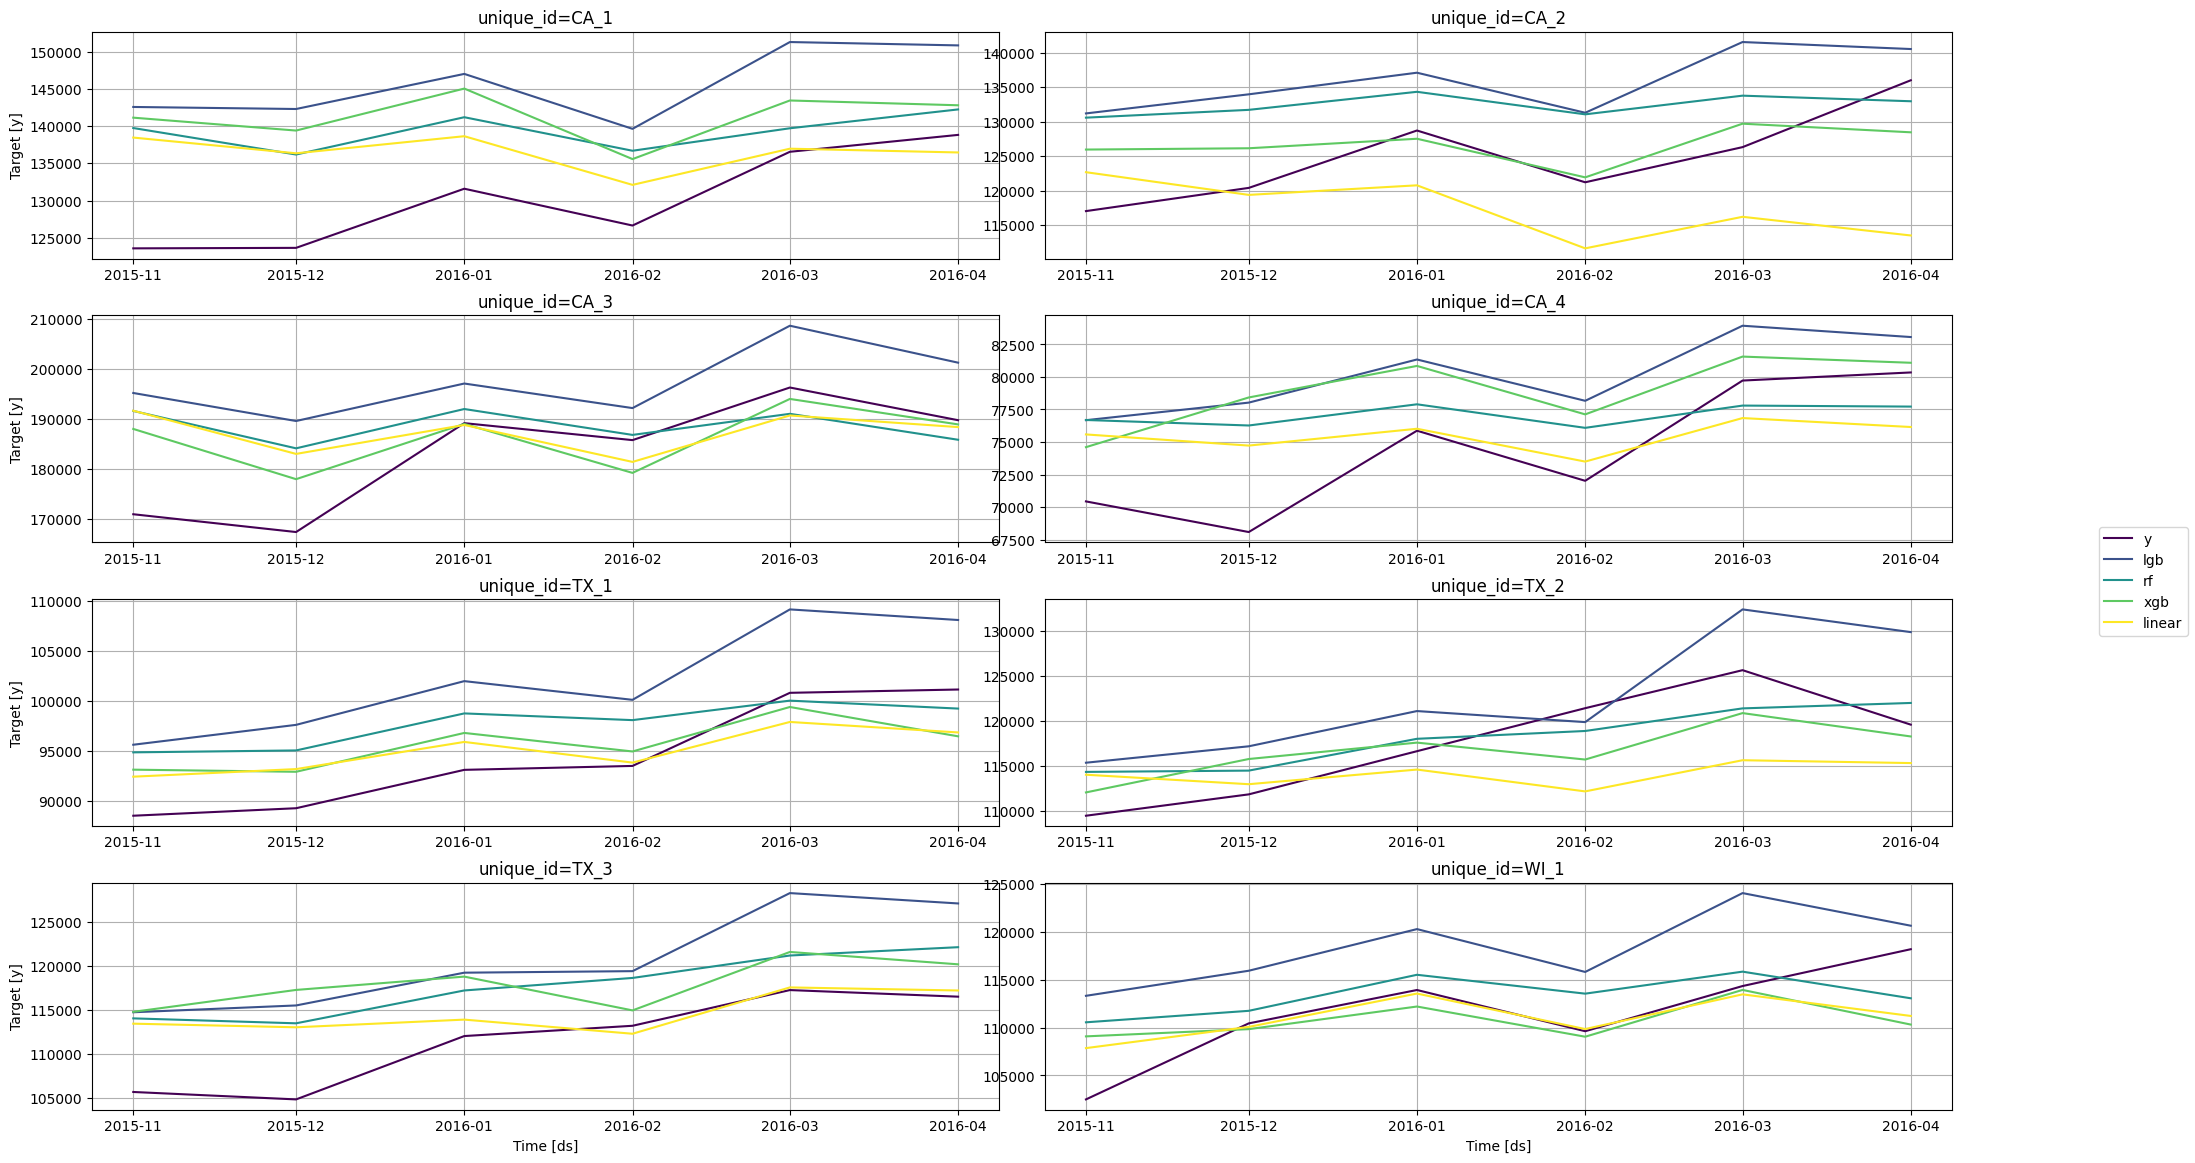

In [21]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [22]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [23]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], df_test['y']))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------lgb-----------------
Mean Absolute Error: 9603.65
Mean absolute percentage error: 7.964035322678953
Root mean squared error: 10884.1966194111
R2: 0.8564089434156668


------------------rf-----------------
Mean Absolute Error: 6764.833333333333
Mean absolute percentage error: 5.562599675477762
Root mean squared error: 8766.634348482889
R2: 0.9068462334860474


------------------xgb-----------------
Mean Absolute Error: 6001.3
Mean absolute percentage error: 4.99505116153475
Root mean squared error: 7906.87527198113
R2: 0.9242217781800389


------------------linear-----------------
Mean Absolute Error: 6510.066666666667
Mean absolute percentage error: 5.2109356986857325
Root mean squared error: 9073.052035193743
R2: 0.9002204738178778




## Analisando o desempenho do melhor modelo

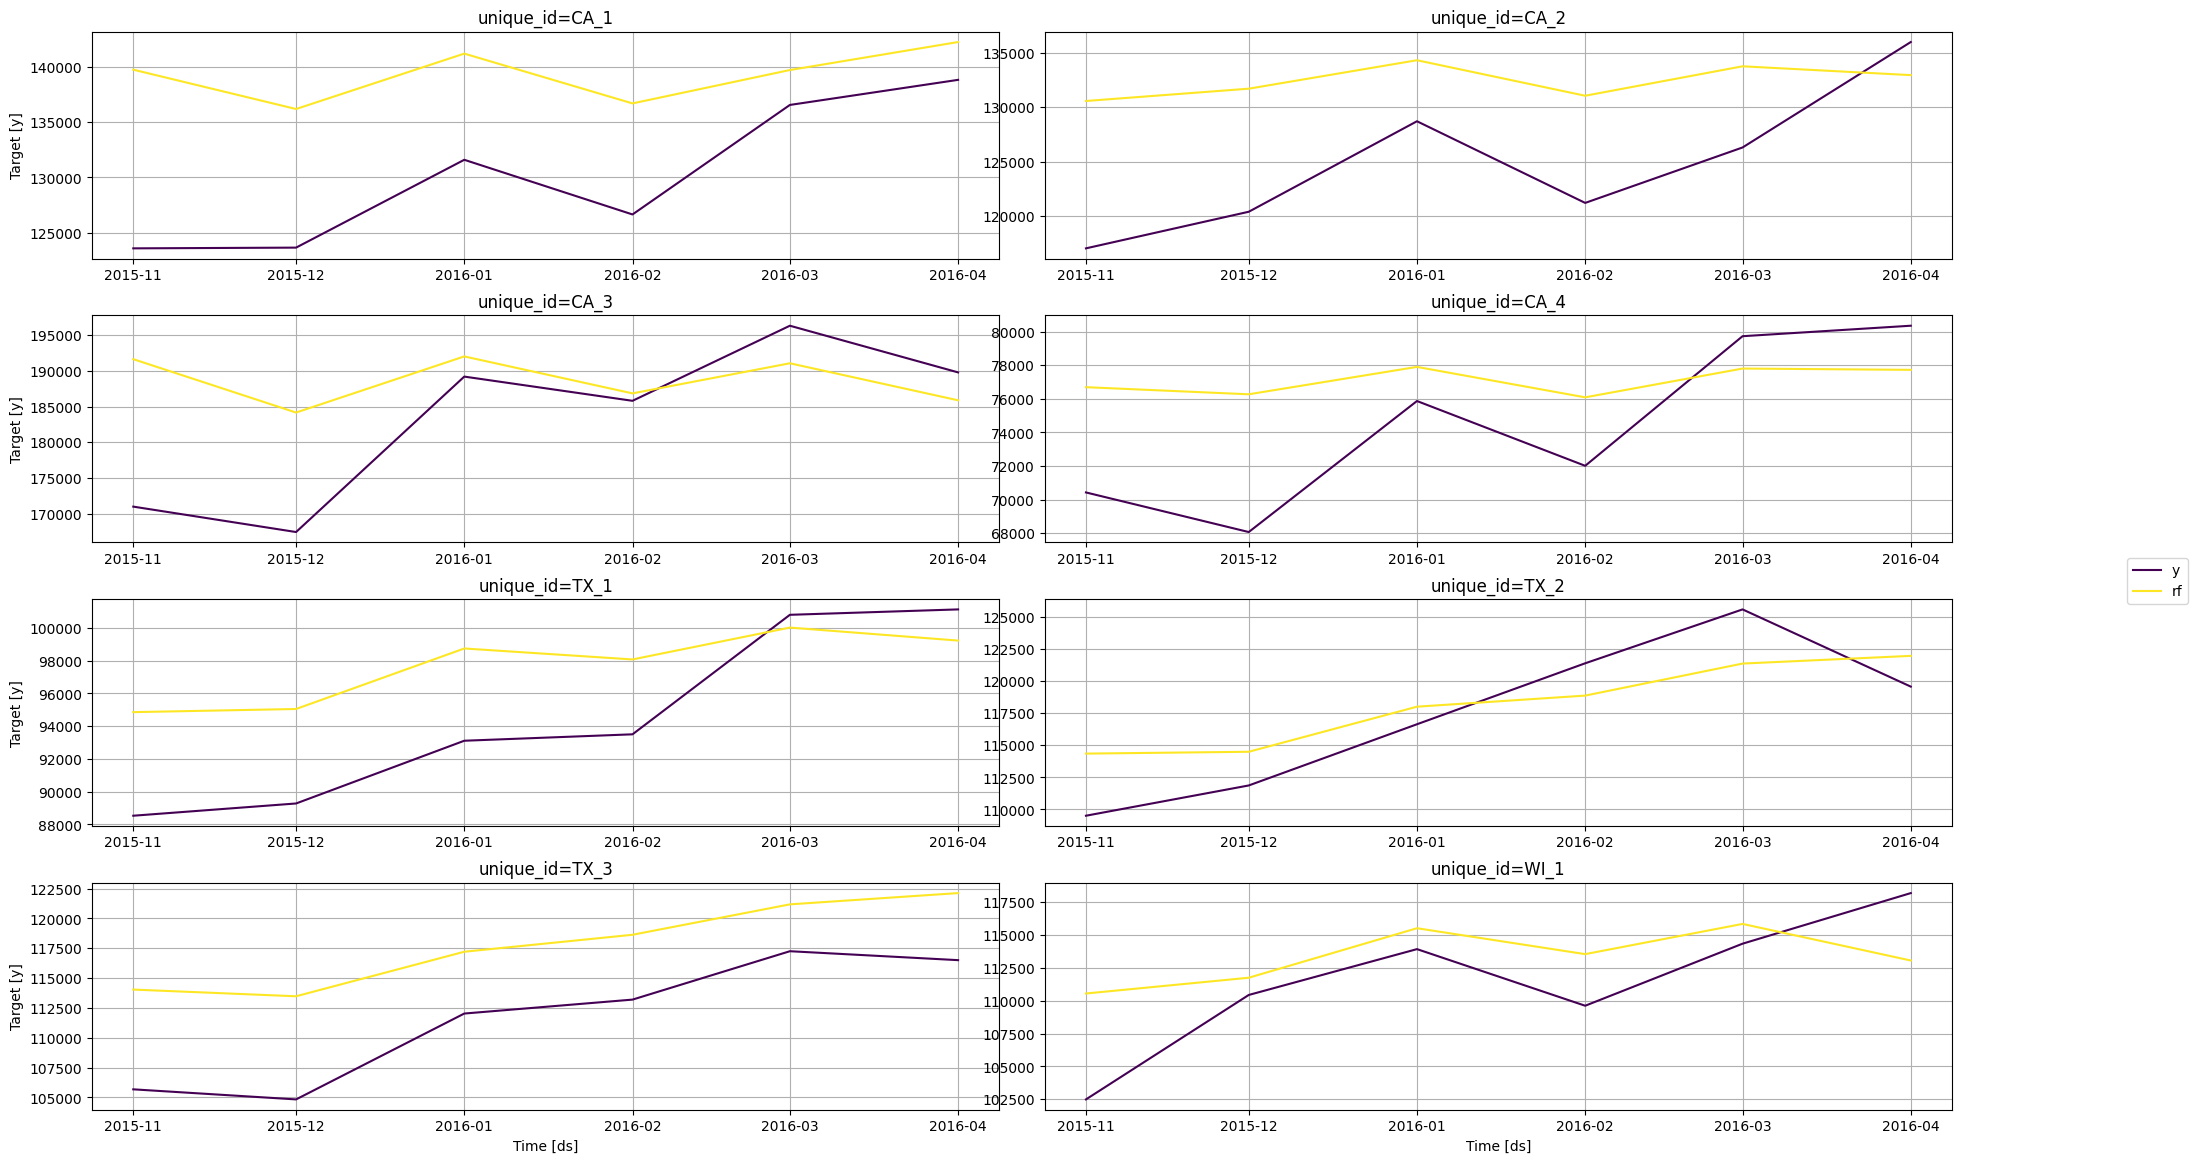

In [29]:
plot_series(df_test, preds[['unique_id', 'ds', 'rf']], plot_random=False)

In [30]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'rf']]

## Previsão dos próximos 6 meses

In [31]:
models={
         'rf' : AutoRandomForest()
        }

In [32]:
dados_full = pd.concat([df_train, df_test])

In [33]:
auto_mlf_full = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [34]:
auto_mlf_full.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=6,
)

[I 2024-07-10 23:41:31,462] A new study created in memory with name: no-name-011ec8c8-77b5-4661-b868-df59308026bb
[I 2024-07-10 23:41:33,319] Trial 0 finished with value: 0.04368264473813157 and parameters: {'n_estimators': 571, 'max_depth': 8, 'min_child_samples': 61, 'max_features': 0.7724415914984484, 'criterion': 'absolute_error', 'target_transforms_idx': 2, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.04368264473813157.
[I 2024-07-10 23:41:36,253] Trial 1 finished with value: 0.04131607201130058 and parameters: {'n_estimators': 877, 'max_depth': 10, 'min_child_samples': 80, 'max_features': 0.7307396811264659, 'criterion': 'squared_error', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 1 with value: 0.04131607201130058.
[I 2024-07-10 23:41:41,075] Trial 2 finished with value: 0.057911937022788136 and parameters: {'n_estimators': 947, 'max_depth': 7, 'min_child_samples': 36,

AutoMLForecast(models={'rf': AutoModel(model=RandomForestRegressor)})

In [35]:
preds = auto_mlf_full.predict(6)

In [36]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

# Exportando os arquivos

# Exportando o pickle

In [37]:
# with open('loja.pkl', 'wb') as f:
#     pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [38]:
# preds.to_csv('previsao_lojas.csv', index=False)

# Validação

In [ ]:
# tabela_validacao.to_csv('validacao_lojas.csv', index=False)